#### Load data sets

In [1]:
import pandas as pd
import import_ipynb
from utilities import *
from preprocessing import *
from vectorization import *
from knn import *

data_sets_directory = "../data_sets"
columns = ["id","title","content","category"]
# read data sets
data_set  = pd.read_csv(f"{data_sets_directory}/data_set.tsv"  , delimiter="\t", names = columns, header = 0)
train_set = pd.read_csv(f"{data_sets_directory}/train_set.tsv" , delimiter="\t", names = columns, header = 0)
test_set  = pd.read_csv(f"{data_sets_directory}/test_set.tsv"  , delimiter="\t", names = columns, header = 0)


# display dataframes
display(data_set.shape,data_set.head(3))
display(train_set.shape,train_set.head(3))
display(test_set.shape,test_set.head(3))

importing Jupyter notebook from utilities.ipynb
importing Jupyter notebook from preprocessing.ipynb
importing Jupyter notebook from vectorization.ipynb
importing Jupyter notebook from knn.ipynb


(2225, 4)

,id,title,content,category
0,1,Ad sales boost Time Warner profit\n,\n Quarterly profits at US media giant TimeWa...,business
1,2,Dollar gains on Greenspan speech\n,\n The dollar has hit its highest level again...,business
2,3,Yukos unit buyer faces loan claim\n,\n The owners of embattled Russian oil giant ...,business


(1780, 4)

,id,title,content,category
0,842,Incredibles win animation awards\n,\n The Incredibles movie has beaten Shrek 2 t...,entertainment
1,1749,Hantuchova in Dubai last eight\n,\n Daniela Hantuchova moved into the quarter-...,sport
2,2119,More power to the people says HP\n,\n The digital revolution is focused on letti...,tech


(445, 4)

,id,title,content,category
0,385,Tate & Lyle boss bags top award\n,\n Tate & Lyle's chief executive has been nam...,business
1,1984,Halo 2 sells five million copies\n,\n Microsoft is celebrating bumper sales of i...,tech
2,986,MSPs hear renewed climate warning\n,\n Climate change could be completely out of ...,politics


#### Preprocessing

In [2]:
start_time = timer()

# associate category names with numerical index
data_set["category_id"] = data_set["category"].factorize()[0]

# concatenate title and content
data_set["title_and_content"] = data_set["title"] + " " + data_set["content"]
# some stop words for better results
more_stop_words = ["say","said","want","thing","may","see","make","look","likely","well","told","uses","used","use","bn","mr","year","people","new"]
# execute preprocessing for "title_and_content" column
data_set = clean_stem_lemmatize_tokens_column(data_set, "title_and_content", more_stop_words, True)

columns = ["id","title","content","category"]
train_set = pd.merge(train_set, data_set, on = columns)
test_set  = pd.merge(test_set , data_set, on = columns)

timer(start_time)

'Time spent: 0:0:25'

#### Roc plot function

In [3]:
from scipy import interp
from itertools import cycle
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.neighbors import KNeighborsClassifier

def roc_plot(model_name, model, train_X, train_Y, test_X, test_Y, vectorizer_name, directory):
    train_Y = label_binarize(train_Y, classes=[0, 1, 2, 3, 4])
    test_Y = label_binarize(test_Y, classes=[0, 1, 2, 3, 4])
    number_of_classes = train_Y.shape[1]

    # calculate score
    classifier = OneVsRestClassifier(model)
    if model_name == "SVM":
        score_Y = classifier.fit(train_X, train_Y).decision_function(test_X)
    else:
        score_Y = classifier.fit(train_X, train_Y).predict_proba(test_X)

    # calculate roc curve an roc area for each class
    roc_auc = dict()
    fpr = dict()
    tpr = dict()
    thresholds = dict()
    for i in range(number_of_classes):
        fpr[i], tpr[i], thresholds[i] = roc_curve(test_Y[:, i], score_Y[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # calculate micro average roc curve and roc area
    fpr["micro"],tpr["micro"],thresholds["micro"] = roc_curve(test_Y.ravel(), score_Y.ravel())
    roc_auc["micro"] = auc(fpr["micro"],tpr["micro"])
    
    # plot next to each other
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 4))

    # plot roc curve
    axes[0].plot(fpr[2],tpr[2],color="indigo",lw=2,label="ROC curve (area = %0.2f)" % roc_auc[2])
    axes[0].plot([0,1],[0,1],color="navy",lw=2,linestyle="--")
    axes[0].set_xlim([0.0,1.0])
    axes[0].set_ylim([0.0,1.05])
    axes[0].set_xlabel("False Positive Rate")
    axes[0].set_ylabel("True Positive Rate")
    axes[0].set_title(f"{model_name}_{vectorizer_name}: Roc curve")
    axes[0].legend(loc="lower right")
    
    # aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(number_of_classes)]))

    # interpolate roc curves
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(number_of_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # calculate average and auc
    mean_tpr /= number_of_classes
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # plot multi-class roc curves
    colors = cycle(["aqua","darkorange","cornflowerblue","green","grey"])
    for i, color in zip(range(number_of_classes), colors):
        axes[1].plot(fpr[i],tpr[i],color=color,lw=2,label=f"ROC curve of class {i} (area = {roc_auc[i]})")

    axes[1].plot([0,1],[0,1],"k--",lw=2)
    axes[1].set_xlim([0.0,1.0])
    axes[1].set_ylim([0.0,1.05])
    axes[1].set_xlabel("False Positive Rate")
    axes[1].set_ylabel("True Positive Rate")
    axes[1].set_title(f"{model_name}_{vectorizer_name}: Multi-class Roc curves")
    axes[1].legend(loc="lower right")

    # save plot as png
    create_directory(directory)
    plt.savefig(f"{directory}/{model_name}_{vectorizer_name}_roc_curves.png".lower())

## Classification

Classification is a process related to categorization, the process in which ideas and objects are recognized, differentiated and understood. Categorization is an activity that consists of putting things (objects, ideas, people) into categories (classes, types, index) based on their similarities or common criteria. It allows humans to organize things, objects, and ideas that exist around them and simplify their understanding of the world.

In [4]:
import warnings
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

# hide warnings
warnings.filterwarnings("ignore")

def execute_model(model, model_name,train_set, test_set, x_column, label_column, vectorizer_name):
    start_time = timer()
    
    if vectorizer_name == "Bow":
        train_X, test_X = bag_of_words_calculate(train_set, test_set, x_column)
    elif vectorizer_name == "Tf_Idf":
        train_X, test_X = tf_idf_calculate(train_set, test_set, x_column)
    # calculate labels
    train_Y = np.asarray(train_set[label_column].tolist())
    test_Y  = np.asarray(test_set[label_column].tolist())
    
    model.fit(train_X,train_Y)
    prediction = model.predict(test_X)
    
    # display report
    print(f"Model:      {model_name}")
    print(f"Vectorizer: {vectorizer_name}")
    print(classification_report(test_Y, prediction))

    timer(start_time)

    roc_plot(model_name, model, train_X, train_Y, test_X, test_Y, vectorizer_name, "./classification_output")

#### Run models

Model:      MultinomialNB
Vectorizer: Bow
              precision    recall  f1-score   support

           0       0.92      0.90      0.91       111
           1       0.93      0.96      0.95        74
           2       0.90      0.90      0.90        86
           3       0.98      0.96      0.97       108
           4       0.88      0.91      0.90        66

    accuracy                           0.93       445
   macro avg       0.92      0.93      0.92       445
weighted avg       0.93      0.93      0.93       445



'Time spent: 0:0:0'

Model:      SVM
Vectorizer: Bow
              precision    recall  f1-score   support

           0       0.91      0.92      0.91       111
           1       0.93      0.96      0.95        74
           2       0.92      0.91      0.91        86
           3       0.98      0.97      0.98       108
           4       0.94      0.92      0.93        66

    accuracy                           0.94       445
   macro avg       0.94      0.94      0.94       445
weighted avg       0.94      0.94      0.94       445



'Time spent: 0:0:1'

Model:      Random_Forest
Vectorizer: Bow
              precision    recall  f1-score   support

           0       0.82      0.91      0.86       111
           1       0.89      0.88      0.88        74
           2       0.89      0.85      0.87        86
           3       0.97      0.95      0.96       108
           4       0.87      0.80      0.83        66

    accuracy                           0.89       445
   macro avg       0.89      0.88      0.88       445
weighted avg       0.89      0.89      0.89       445



'Time spent: 0:0:0'

Model:      KNN
Vectorizer: Bow
              precision    recall  f1-score   support

           0       0.80      0.77      0.78       111
           1       0.81      0.77      0.79        74
           2       0.91      0.59      0.72        86
           3       0.63      0.99      0.77       108
           4       0.95      0.62      0.75        66

    accuracy                           0.77       445
   macro avg       0.82      0.75      0.76       445
weighted avg       0.81      0.77      0.76       445



'Time spent: 0:0:0'

Model:      MultinomialNB
Vectorizer: Tf_Idf
              precision    recall  f1-score   support

           0       0.92      0.91      0.91       111
           1       0.96      0.95      0.95        74
           2       0.91      0.90      0.90        86
           3       0.98      0.97      0.98       108
           4       0.87      0.92      0.90        66

    accuracy                           0.93       445
   macro avg       0.93      0.93      0.93       445
weighted avg       0.93      0.93      0.93       445



'Time spent: 0:0:0'

Model:      SVM
Vectorizer: Tf_Idf
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       111
           1       0.00      0.00      0.00        74
           2       0.00      0.00      0.00        86
           3       0.24      1.00      0.39       108
           4       0.00      0.00      0.00        66

    accuracy                           0.24       445
   macro avg       0.05      0.20      0.08       445
weighted avg       0.06      0.24      0.09       445



'Time spent: 0:0:2'

Model:      Random_Forest
Vectorizer: Tf_Idf
              precision    recall  f1-score   support

           0       0.86      0.92      0.89       111
           1       0.86      0.95      0.90        74
           2       0.89      0.86      0.88        86
           3       0.96      0.93      0.94       108
           4       0.91      0.80      0.85        66

    accuracy                           0.90       445
   macro avg       0.90      0.89      0.89       445
weighted avg       0.90      0.90      0.90       445



'Time spent: 0:0:0'

Model:      KNN
Vectorizer: Tf_Idf
              precision    recall  f1-score   support

           0       0.89      0.82      0.85       111
           1       0.89      0.91      0.90        74
           2       0.86      0.90      0.88        86
           3       0.95      0.96      0.96       108
           4       0.87      0.91      0.89        66

    accuracy                           0.90       445
   macro avg       0.89      0.90      0.90       445
weighted avg       0.90      0.90      0.90       445



'Time spent: 0:0:0'

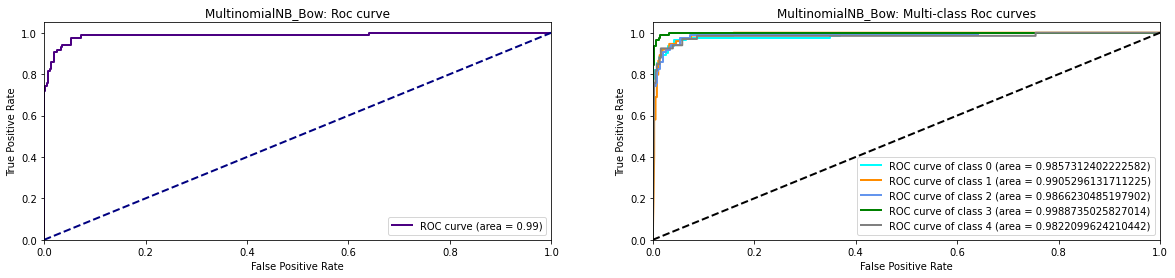

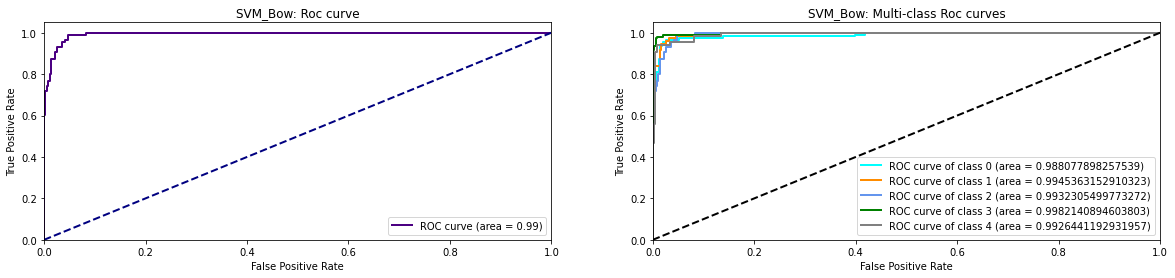

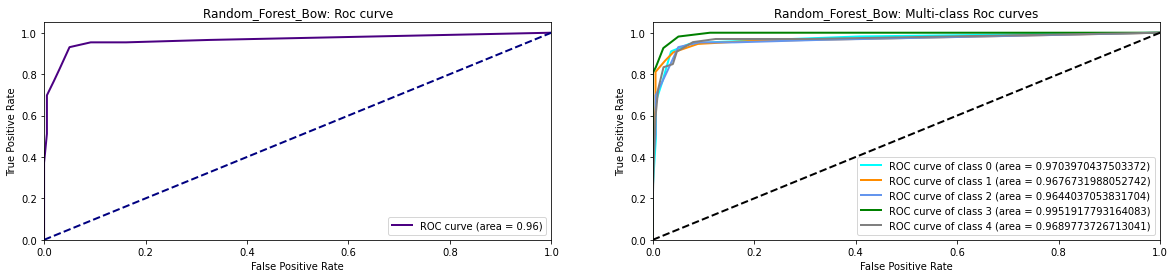

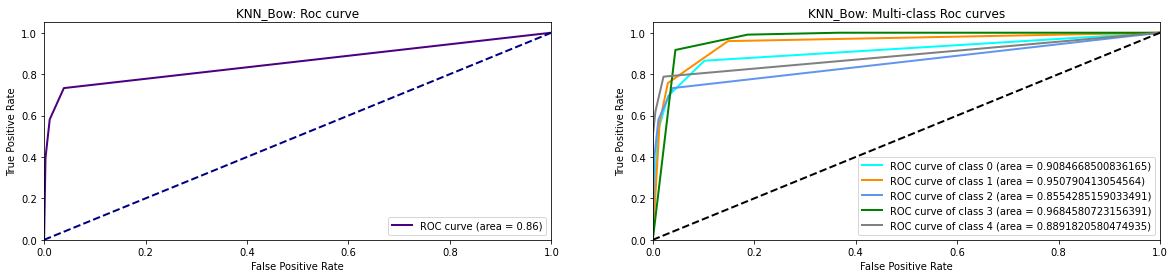

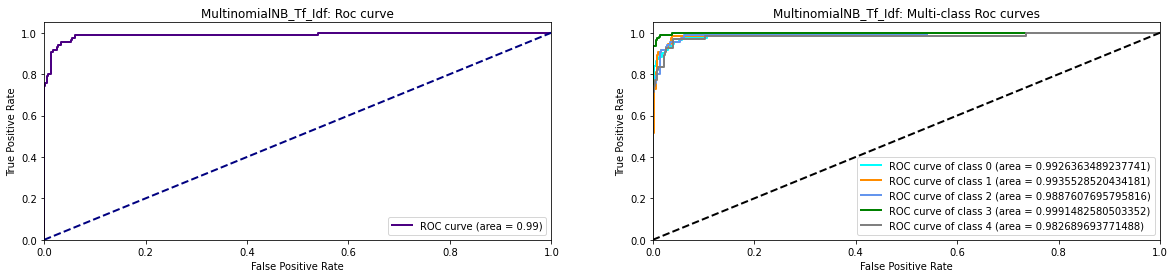

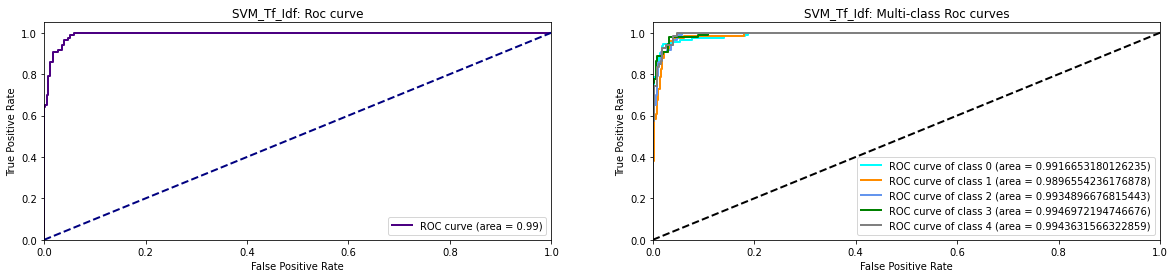

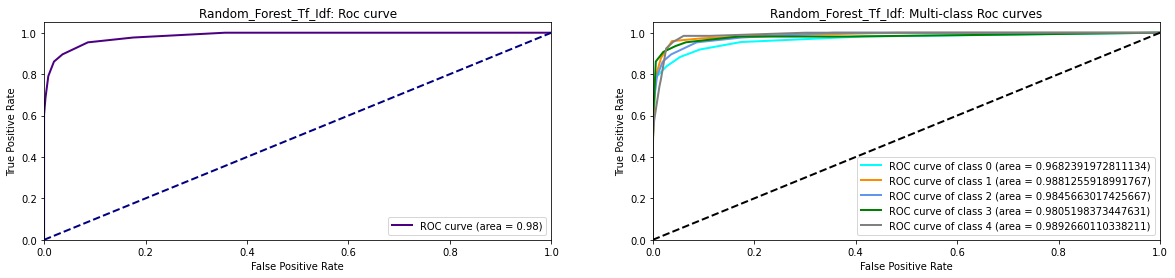

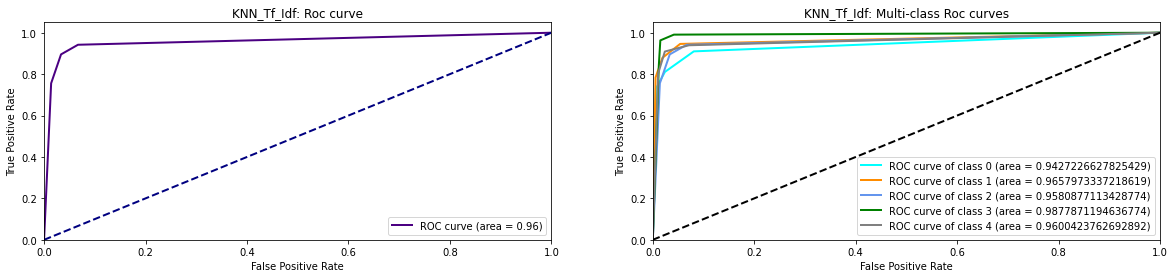

In [5]:
# prepare models
models = list()
models.append(('MultinomialNB', MultinomialNB(alpha = 0)))
models.append(('SVM', SVC()))
models.append(('Random_Forest', RandomForestClassifier(random_state = 0)))
models.append(('KNN', KNeighborsClassifier(n_neighbors=3)))

# BOW
for name, model in models:
    execute_model(model, name, 
                  train_set, test_set, "title_and_content_clean_stems_lemmas", "category_id", "Bow")

# Tf_Idf
for name, model in models:
    execute_model(model, name, 
                  train_set, test_set, "title_and_content_clean_stems_lemmas", "category_id", "Tf_Idf")